In [1]:
import numpy as np
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet

c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
sample_data = pd.DataFrame(
    dict(
        time_idx=np.tile(np.arange(6), 3),
        target=np.array([0,1,2,3,4,5,20,21,22,23,24,25,40,41,42,43,44,45]),
        group=np.repeat(np.arange(3), 6),
        holidays = np.tile(['X','Black Friday', 'X','Christmas','X', 'X'],3),
    )
)
sample_data

,time_idx,target,group,holidays
0,0,0,0,X
1,1,1,0,Black Friday
2,2,2,0,X
3,3,3,0,Christmas
4,4,4,0,X
5,5,5,0,X
6,0,20,1,X
7,1,21,1,Black Friday
8,2,22,1,X
9,3,23,1,Christmas


In [3]:
# create the time-series dataset from the pandas df
dataset = TimeSeriesDataSet(
    sample_data,
    group_ids=["group"],
    target="target",
    time_idx="time_idx",
    max_encoder_length=2,
    max_prediction_length=3,
    time_varying_unknown_reals=["target"],
    static_categoricals=["holidays"],
    target_normalizer=None
)

In [4]:
# pass the dataset to a dataloader
dataloader = dataset.to_dataloader(batch_size=1)

#load the first batch
x, y = next(iter(dataloader))
print(x['encoder_target'])
print(x['groups'])
print('\n')
print(x['decoder_target'])

tensor([[40., 41.]])
tensor([[2]])


tensor([[42., 43., 44.]])


In [5]:
data = pd.read_csv('C:/Users/Daniel/Documents/Universidad Nacional/Diplomado IA/Bases/LD2011_2014.txt', index_col=0, sep=';', decimal=',')
data.index = pd.to_datetime(data.index)
data.sort_index(inplace=True)
data.head(5)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data = data.resample('1h').mean().replace(0., np.nan)
earliest_time = data.index.min()
df=data[['MT_002', 'MT_004', 'MT_005', 'MT_006', 'MT_008' ]]

In [7]:
df_list = []

for label in df:

    ts = df[label]

    start_date = min(ts.fillna(method='ffill').dropna().index)
    end_date = max(ts.fillna(method='bfill').dropna().index)

    active_range = (ts.index >= start_date) & (ts.index <= end_date)
    ts = ts[active_range].fillna(0.)

    tmp = pd.DataFrame({'power_usage': ts})
    date = tmp.index

    tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
    tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')
  
    tmp['days_from_start'] = (date - earliest_time).days
    tmp['date'] = date
    tmp['consumer_id'] = label
    tmp['hour'] = date.hour
    tmp['day'] = date.day
    tmp['day_of_week'] = date.dayofweek
    tmp['month'] = date.month

    #stack all time series vertically
    df_list.append(tmp)

time_df = pd.concat(df_list).reset_index(drop=True)

# match results in the original paper
time_df = time_df[(time_df['days_from_start'] >= 1096)
                & (time_df['days_from_start'] < 1346)].copy()

In [8]:
time_df[['consumer_id','power_usage']].groupby('consumer_id').mean()

,power_usage
consumer_id,
MT_002,27.472588
MT_004,120.573001
MT_005,50.958384
MT_006,183.387773
MT_008,248.884259


In [9]:
#Hyperparameters
#batch size=64
#number heads=4, hidden sizes=160, lr=0.001, gr_clip=0.1

from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer 

max_prediction_length = 24
max_encoder_length = 7*24
training_cutoff = time_df["hours_from_start"].max() - max_prediction_length

training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start <= training_cutoff],
    time_idx="hours_from_start",
    target="power_usage",
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length // 2, 
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=["hours_from_start","day","day_of_week", "month", 'hour'],
    time_varying_unknown_reals=['power_usage'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)


validation = TimeSeriesDataSet.from_dataset(training, time_df, predict=True, stop_randomization=True)

# create dataloaders for  our model
batch_size = 64 
# if you have a strong GPU, feel free to increase the number of workers  
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [10]:
import torch
from pytorch_forecasting import Baseline

actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a b

25.139617919921875

In [11]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import LearningRateMonitor

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()  
logger = TensorBoardLogger("lightning_logs")  

In [13]:
from lightning.pytorch import Trainer

trainer = Trainer(
    max_epochs=45,
    accelerator='cpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4)

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Missing logger folder: lightning_logs\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList   

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 468/468 [1:11:10<00:00,  9.13s/it, v_num=0, train_loss_step=5.900, val_loss=4.450, train_loss_epoch=9.200]

Metric val_loss improved. New best score: 4.453


Epoch 1: 100%|██████████| 468/468 [1:02:05<00:00,  7.96s/it, v_num=0, train_loss_step=4.630, val_loss=4.080, train_loss_epoch=5.210]

Metric val_loss improved by 0.374 >= min_delta = 0.0001. New best score: 4.079


Epoch 2: 100%|██████████| 468/468 [1:04:31<00:00,  8.27s/it, v_num=0, train_loss_step=4.740, val_loss=3.340, train_loss_epoch=4.590]

Metric val_loss improved by 0.738 >= min_delta = 0.0001. New best score: 3.341


Epoch 3: 100%|██████████| 468/468 [1:08:31<00:00,  8.78s/it, v_num=0, train_loss_step=4.110, val_loss=3.240, train_loss_epoch=4.240]

Metric val_loss improved by 0.103 >= min_delta = 0.0001. New best score: 3.238


Epoch 8: 100%|██████████| 468/468 [1:23:03<00:00, 10.65s/it, v_num=0, train_loss_step=2.810, val_loss=4.670, train_loss_epoch=3.060]

Monitored metric val_loss did not improve in the last 5 records. Best score: 3.238. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 468/468 [1:25:45<00:00, 11.00s/it, v_num=0, train_loss_step=2.810, val_loss=4.670, train_loss_epoch=3.060]


In [16]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs\lightning_logs\version_0\checkpoints\epoch=8-step=4212.ckpt


c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\utilities\parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [17]:
# Guardar el modelo
#  # !zip  -r model.zip lightning_logs/lightning_logs/version_1/*

"zip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
# #load our saved model again
# !unzip model.zip
# best_model_path='lightning_logs/lightning_logs/version_1/checkpoints/epoch=8-step=4212.ckpt'
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [18]:
# Start tensorboard
%load_ext tensorboard
%tensorboard - logdir lightning_logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 19432.

In [28]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

In [29]:
predictions = best_tft.predict(val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [30]:
#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

7.499117851257324
tensor([ 0.9451,  9.8251,  2.4851, 10.9125, 13.3278])


In [42]:
results = best_tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions = results[0]
x = results[1]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


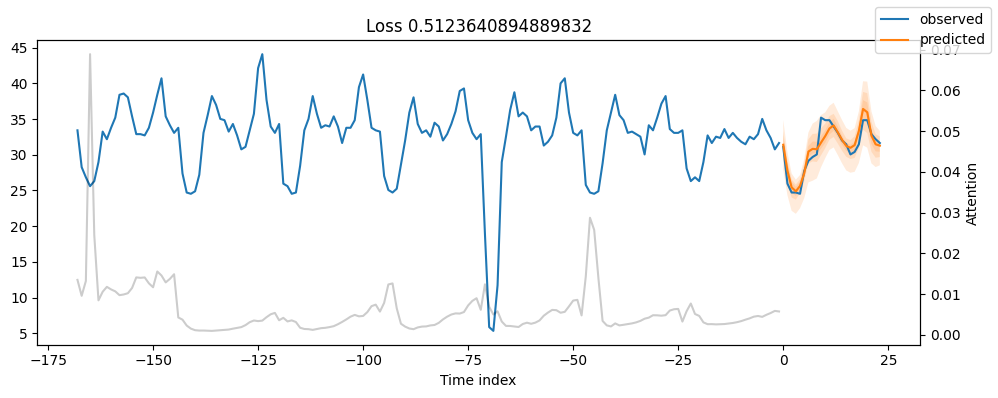

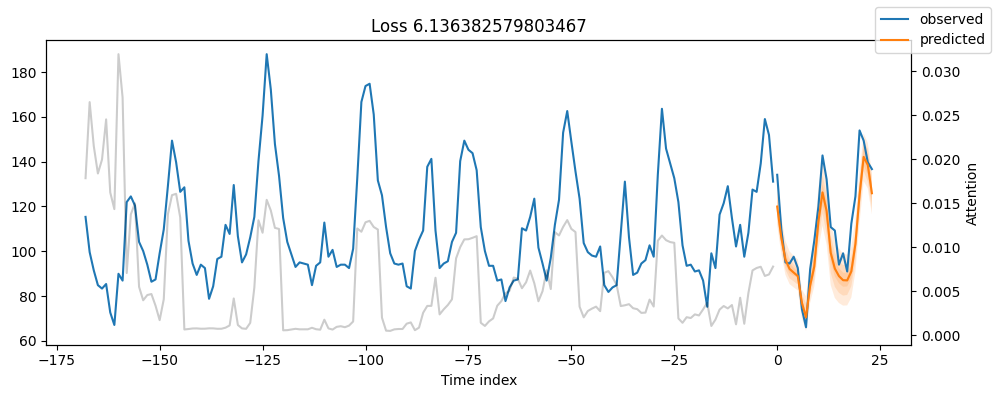

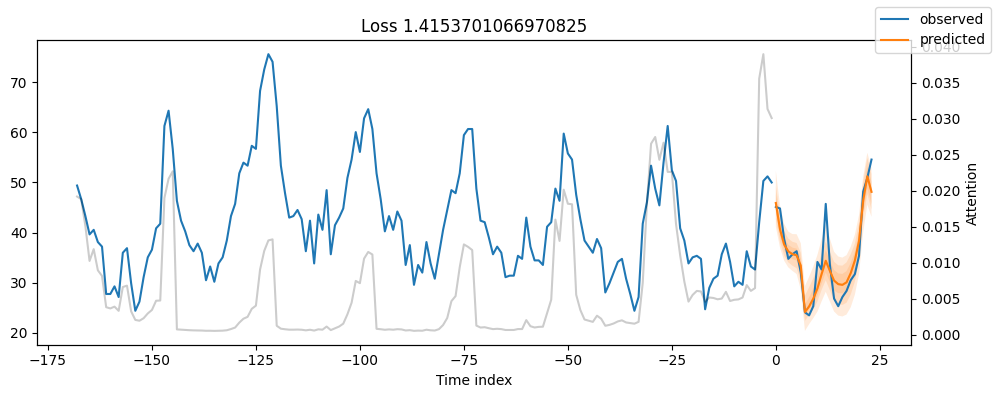

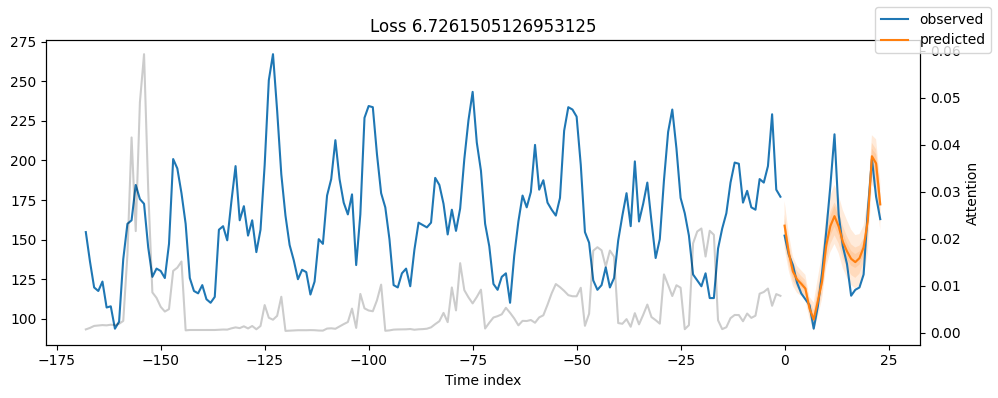

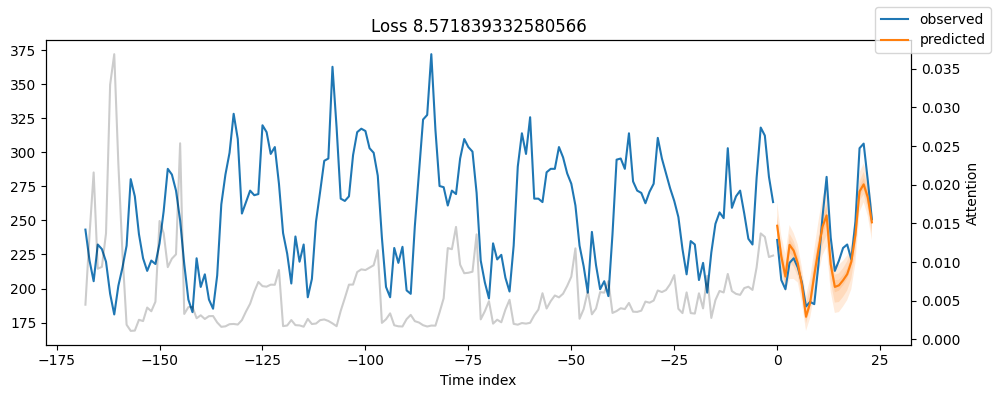

In [43]:
for idx in range(5):  # plot all 5 consumers
    fig, ax = plt.subplots(figsize=(10, 4))
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True,ax=ax)

In [44]:
result = best_tft.predict(
    training.filter(lambda x: (x.consumer_id == "MT_004") & (x.time_idx_first_prediction == 26512)),
    mode="raw",
    return_x=True,
)
raw_prediction = result[0]
x = result[1]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


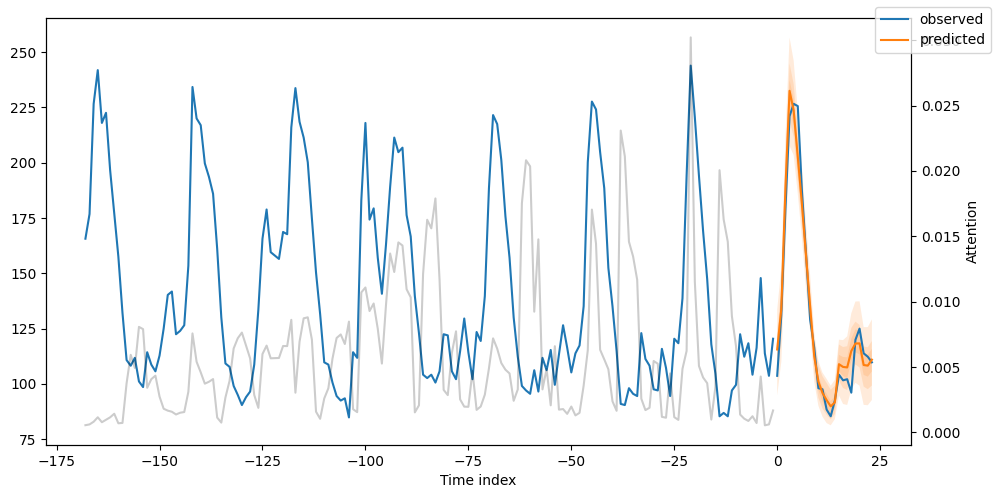

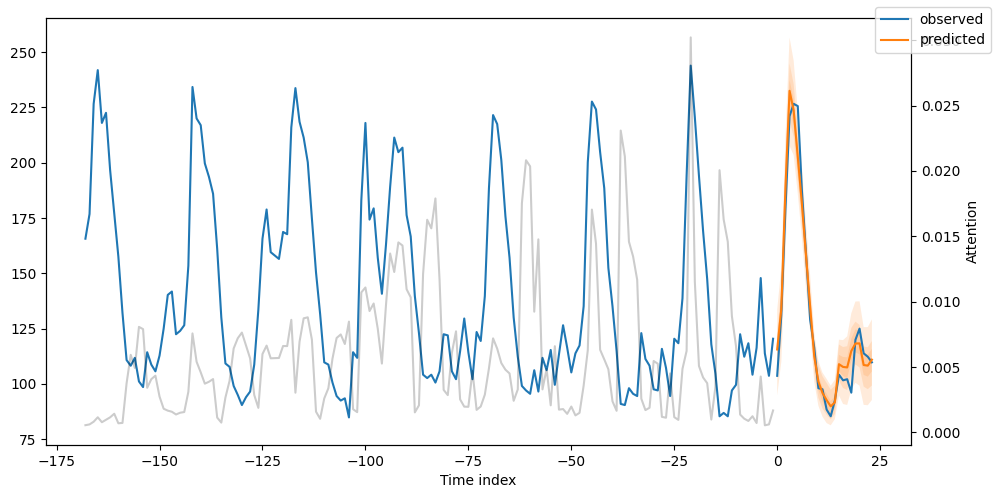

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
best_tft.plot_prediction(x, raw_prediction, idx=0, ax=ax)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


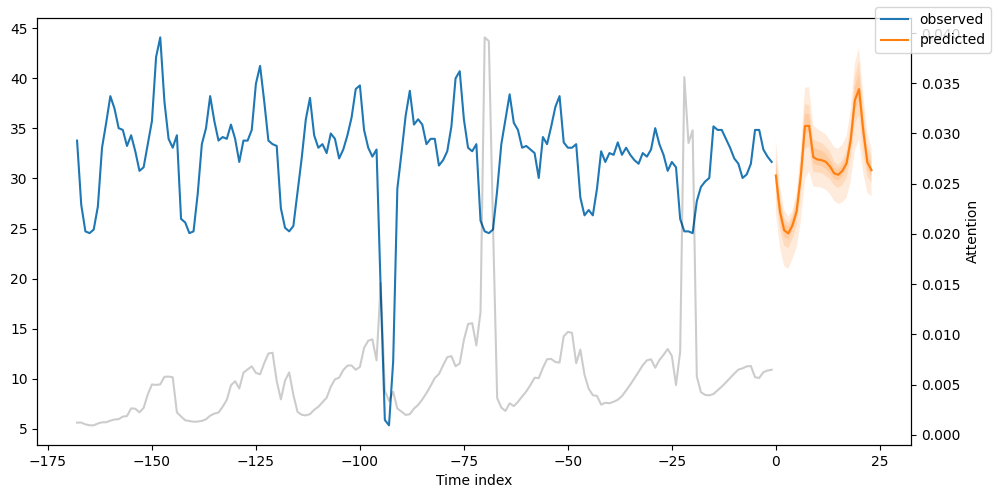

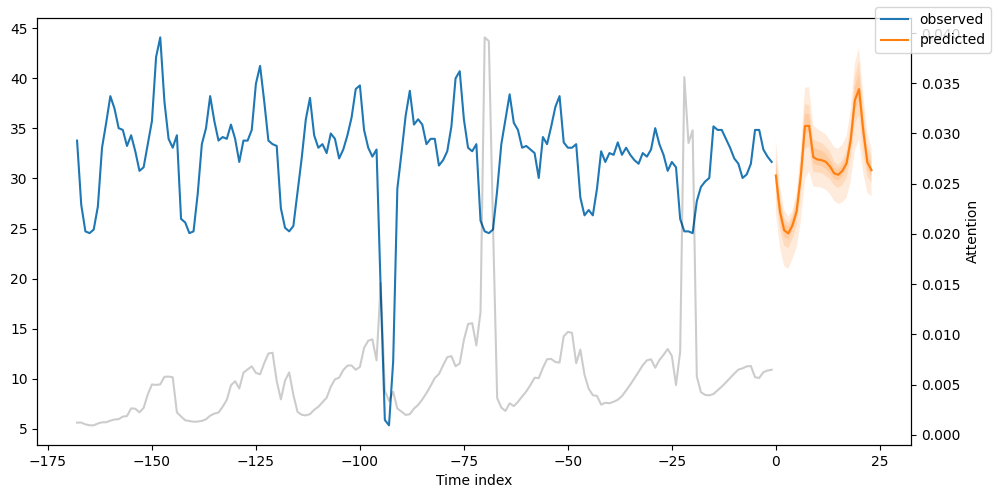

In [47]:
#encoder data is the last lookback window: we get the last 1 week (168 datapoints) for all 5 consumers = 840 total datapoints

encoder_data = time_df[lambda x: x.hours_from_start > x.hours_from_start.max() - max_encoder_length]
last_data = time_df[lambda x: x.hours_from_start == x.hours_from_start.max()]

#decoder_data is the new dataframe for which we will create predictions. 
#decoder_data df should be max_prediction_length*consumers = 24*5=120 datapoints long : 24 datapoints for each cosnumer
#we create it by repeating the last hourly observation of every consumer 24 times since we do not really have new test data
#and later we fix the columns

decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.Hour(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

#fix the new columns
decoder_data["hours_from_start"] = (decoder_data["date"] - earliest_time).dt.seconds / 60 / 60 + (decoder_data["date"] - earliest_time).dt.days * 24
decoder_data['hours_from_start'] = decoder_data['hours_from_start'].astype('int')
decoder_data["hours_from_start"] += encoder_data["hours_from_start"].max() + 1 - decoder_data["hours_from_start"].min()

decoder_data["month"] = decoder_data["date"].dt.month.astype(np.int64)
decoder_data["hour"] = decoder_data["date"].dt.hour.astype(np.int64)
decoder_data["day"] = decoder_data["date"].dt.day.astype(np.int64)
decoder_data["day_of_week"] = decoder_data["date"].dt.dayofweek.astype(np.int64)

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

fig, ax = plt.subplots(figsize=(10, 5))

#create out-of-sample predictions for MT_002
new_prediction_data=new_prediction_data.query(" consumer_id == 'MT_002'")
results2 = best_tft.predict(new_prediction_data, mode="raw", return_x=True)
new_raw_predictions = results2[0]
new_x = results2[1]
best_tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False, ax=ax)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x375 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

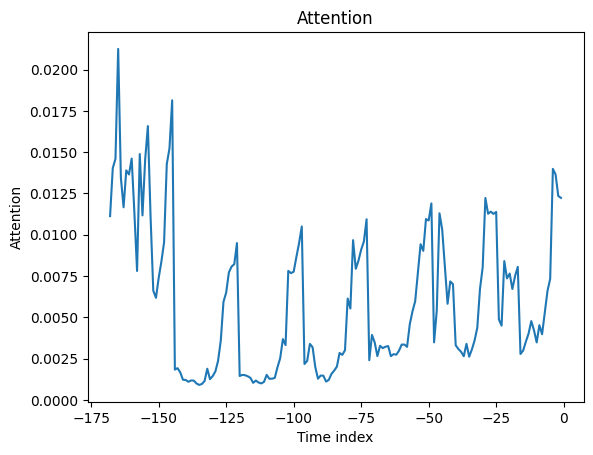

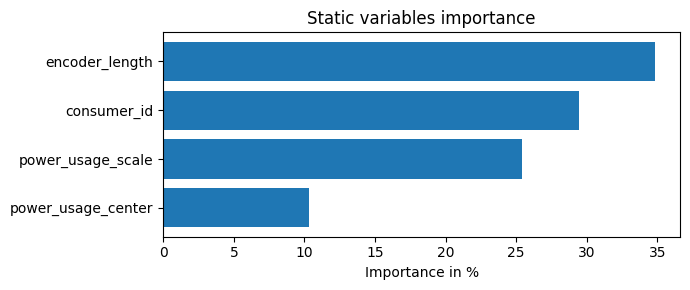

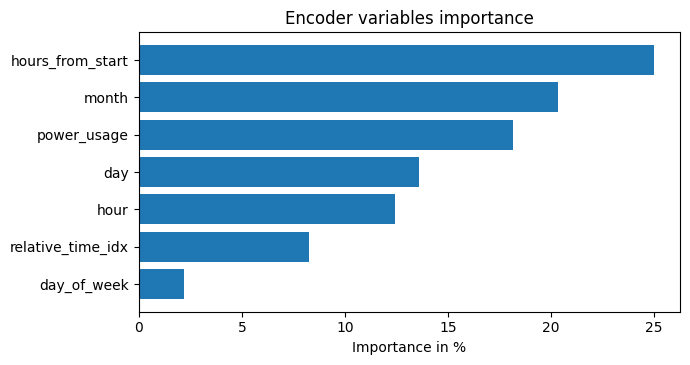

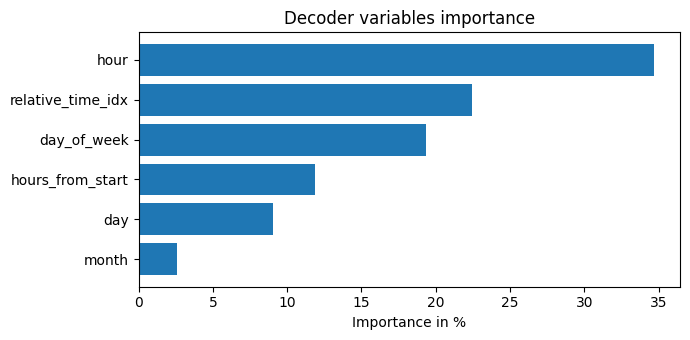

In [48]:
results3 = best_tft.predict(val_dataloader, mode="raw", return_x=True)
raw_predictions = results3[0]
x = results3[1]

interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:478: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
c:\Users\Daniel\anaconda4\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'power_usage_center': <Figure size 1000x500 with 2 Axes>,
 'power_usage_scale': <Figure size 1000x500 with 2 Axes>,
 'hours_from_start': <Figure size 1000x500 with 2 Axes>,
 'day': <Figure size 1000x500 with 2 Axes>,
 'day_of_week': <Figure size 1000x500 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'hour': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'power_usage': <Figure size 1000x500 with 2 Axes>,
 'consumer_id': <Figure size 640x480 with 2 Axes>}

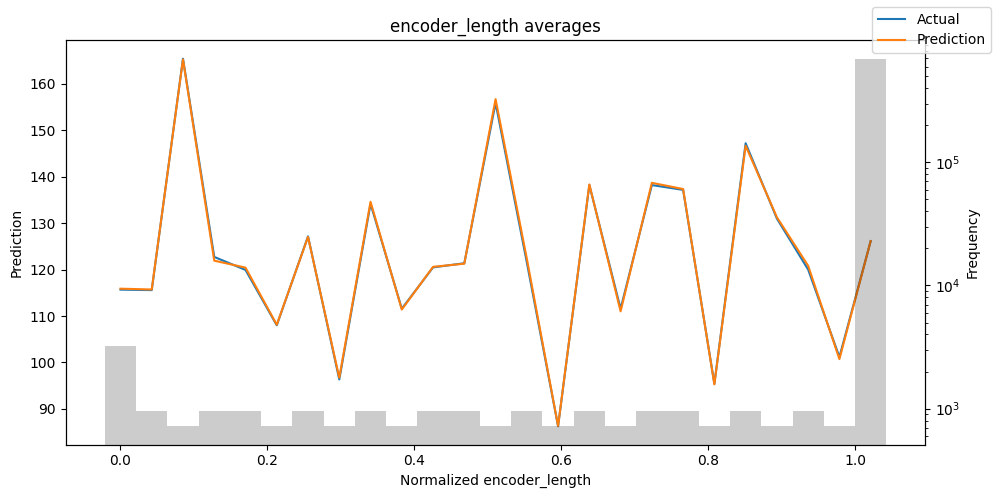

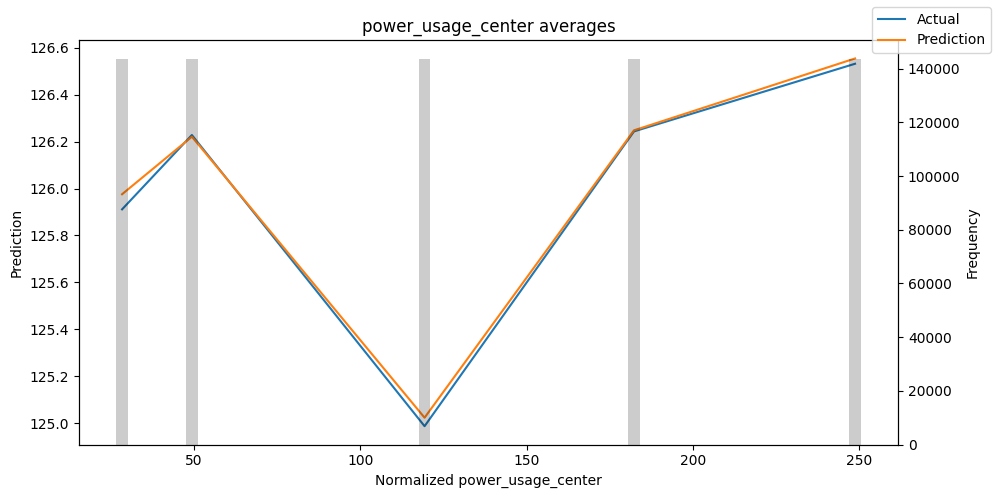

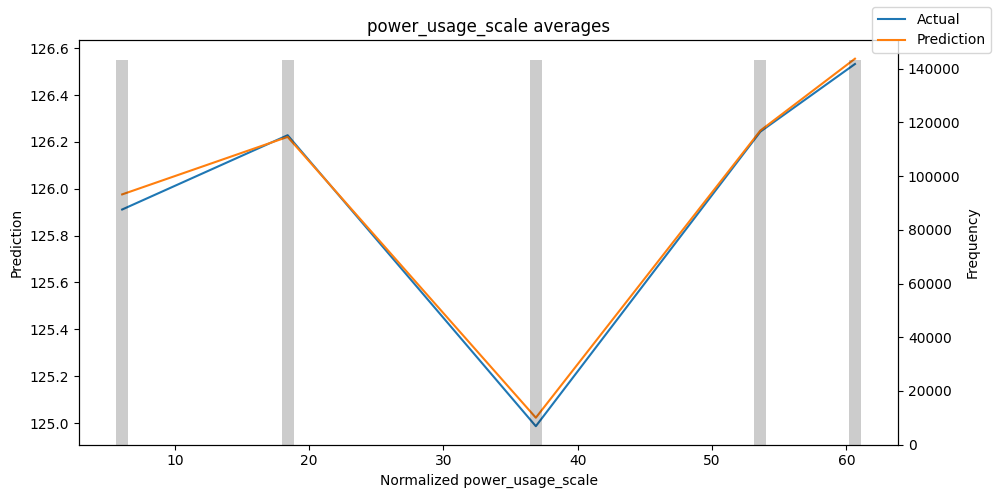

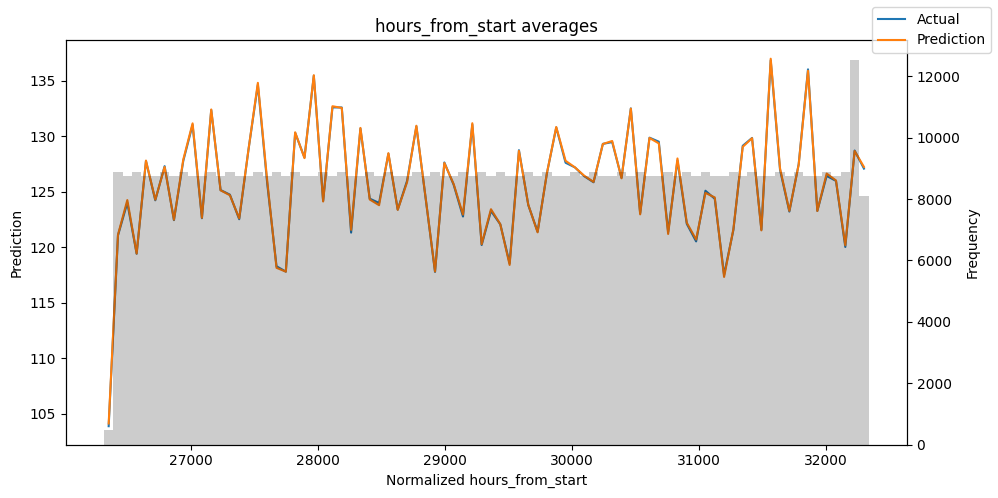

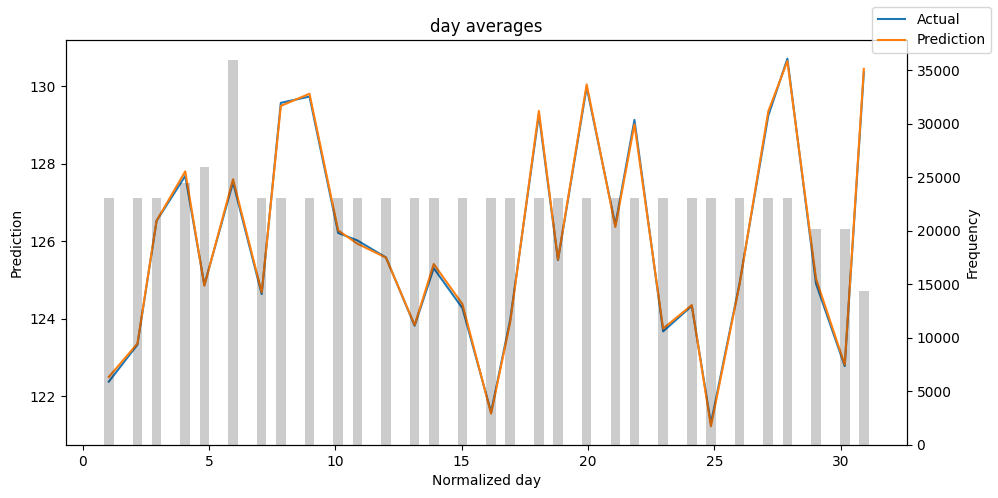

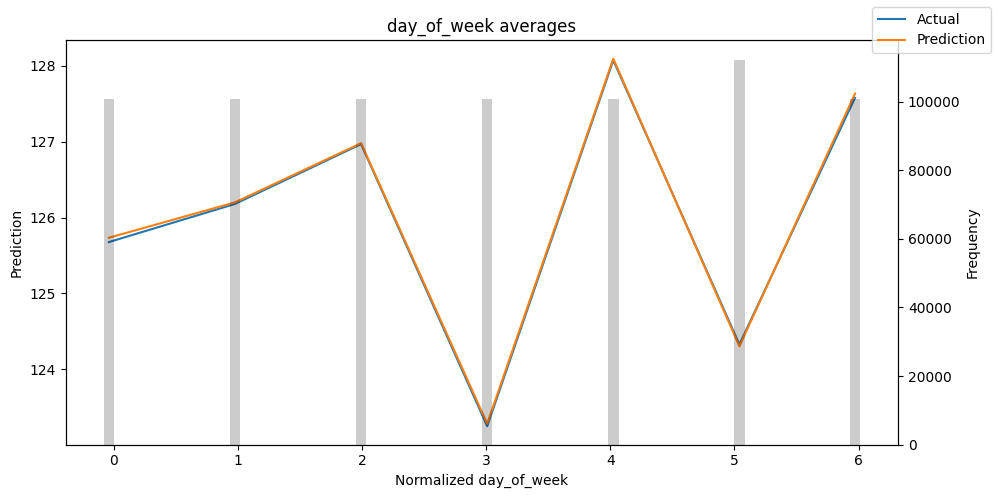

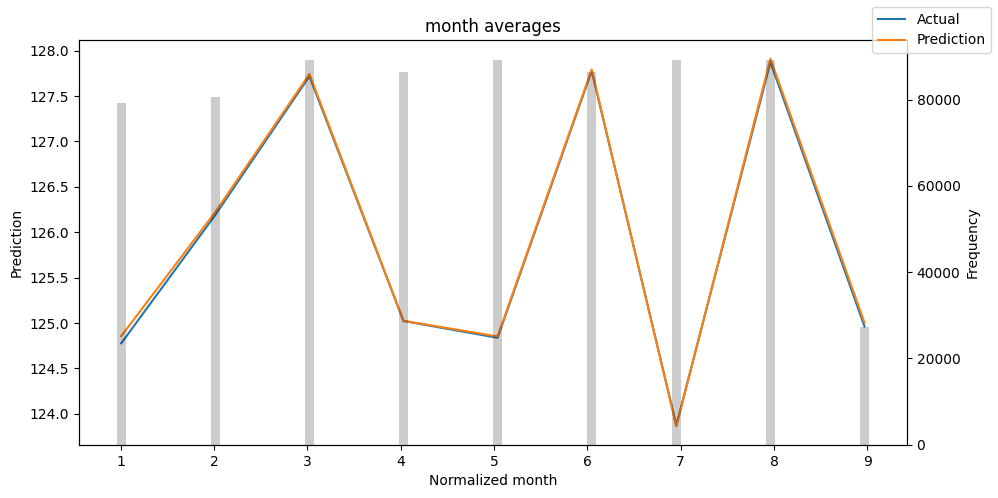

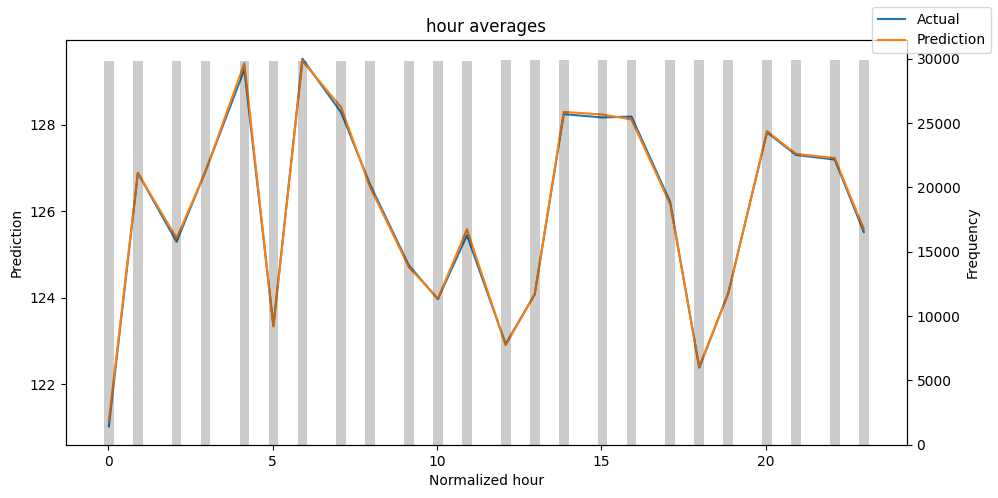

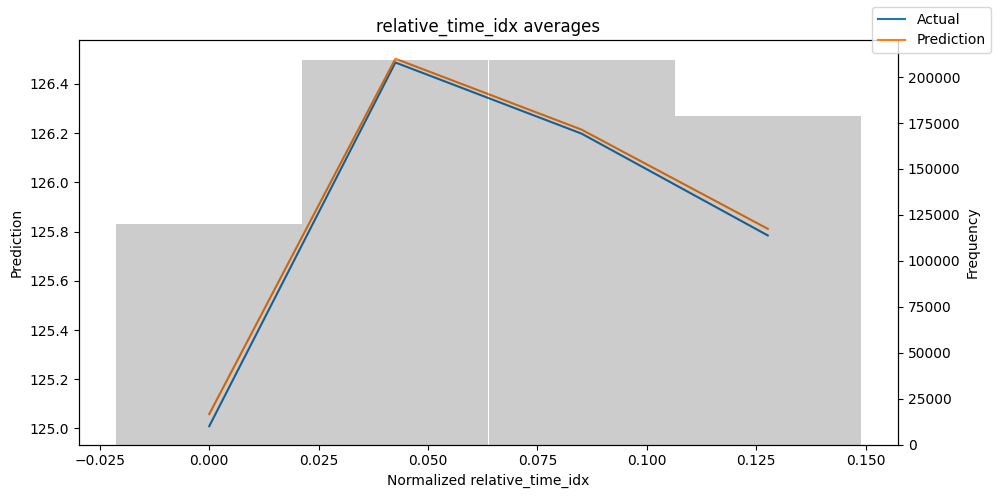

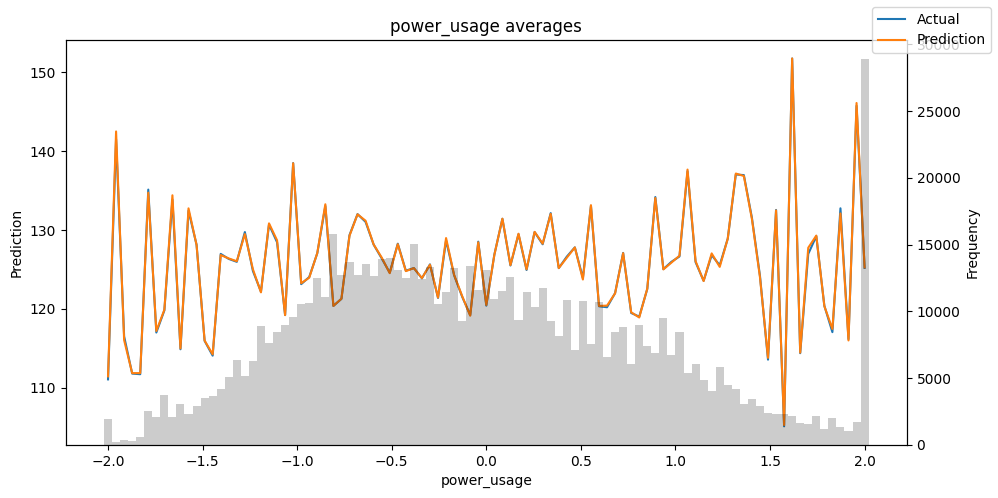

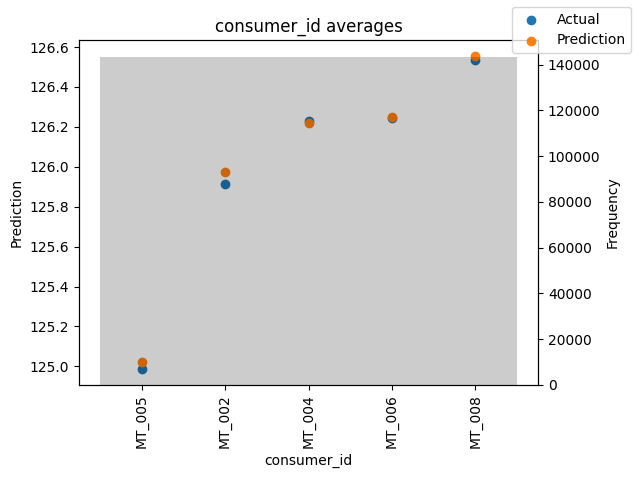

In [49]:
#Analysis on the training set

results4 = best_tft.predict(train_dataloader, return_x=True)
predictions = results4[0]
x = results4[1]

predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [ ]:
# create a new study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=1,
    max_epochs=1,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(30, 128),
    hidden_continuous_size_range=(30, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False 
)

# save study results
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# print best hyperparameters
print(study.best_trial.params)